### 조건에 따라서 분기하는 그래프 생성
- 기분에 따라서 응답 하는 시스템 만들기
- 긍정이냐 부정이냐 에 따라 다르게 답변
1. 입력한 말이 긍정이냐, 부정이냐, 중립이냐 세개로 나누도록 분석하는 노드
2. 긍정노드 / 중립노드 / 부정노드 

In [1]:
from typing import Annotated, TypedDict, Literal
from langgraph.graph import StateGraph, START, END
from operator import add
from langgraph.graph.message import add_messages
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage
from langchain_openai import ChatOpenAI

from dotenv import load_dotenv
load_dotenv()

True

In [2]:
# 1. state
class EmotionState(TypedDict):
    user_input : str
    
    # emotion : Literal["positive", "negative", "neutral"]
    
    emotion : str
    
    response : str

In [3]:
test_state = EmotionState(
    user_input = "오늘 기분이 좋아요",
    emotion = "positive",
    response = "오늘 기분이 좋으시다면 좋은 하루 보내세요"
)
test_state

{'user_input': '오늘 기분이 좋아요',
 'emotion': 'positive',
 'response': '오늘 기분이 좋으시다면 좋은 하루 보내세요'}

In [4]:
# llm 초기화
llm = ChatOpenAI(
    model = "gpt-4.1-mini",
    temperature = 0.2
)

In [5]:
# 감정 분석 노드
def analyze_emotion(state: EmotionState) -> EmotionState:
    """"
    사용자가 입력을 하고, 그 입려의 감정을 세가지로 분석하는 노드다.
    emotion : 이 문장의 감정상태
    """

    user_input = state.get("user_input", "안녕하세요 기분이 좋아요")

    prompt = f"""다음 문장의 감정을 분석해주세요.
    'positive', 'negative', 'netural' 중 하나로 답변하세요
    [입력한 텍스트]
    {user_input}"""


    # 예시 : 시스템 프롬프트일 경우
    # ["SystemMessages(content="너는 감정 분석 전문가야"),
    # ]

    response = llm.invoke(prompt)
    emotion = response.content.strip().lower()

    print("감정 분석 결과", emotion)
    return {
        "emtion" : emotion
    }

In [17]:
# 1. 긍정 노드
def pos_res(state: EmotionState) -> dict:
    print("긍정 노드 실행중입니다.")
    return {
        "response" : "긍정 노드 실행중입니다."
    }

# 2. 부정 노드
def neg_res(state: EmotionState) -> dict:
    print("부정 노드 실행중입니다.")
    return {
        "response" : "부정 노드 실행중입니다."
    }

# 3. 중립 노드
def net_res(state: EmotionState) -> dict:
    print("중립 노드 실행중입니다.")
    return {
        "response" : "중립 노드 실행중입니다."
    }

In [18]:
# 4. conditional 라우팅
def conditional_rout(state: EmotionState):
    emotion = state.get("emotion", "netural")

    if emotion == "positive":
        return "positive"
    elif emotion == "negative":
        return "negative"
    else:
        return "netural"

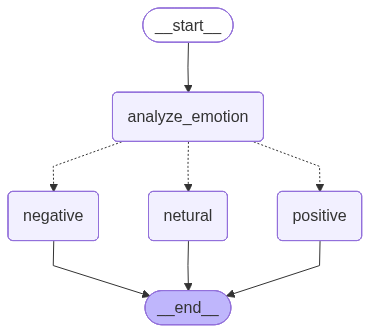

In [19]:
# 그래프 만들기
workflow = StateGraph(EmotionState)
workflow.add_node("analyze_emotion", analyze_emotion)

# 시작점 
workflow.set_entry_point("analyze_emotion")

# 끝점
# workflow.set_finish_point("analyze_emotion")

# 추가 - 바뀔점
workflow.add_node("positive", pos_res)
workflow.add_node("negative", neg_res)
workflow.add_node("netural", net_res)

# 엣지 추가
workflow.add_conditional_edges(
    "analyze_emotion",
    conditional_rout,
    {
        "positive" : "positive",
        "negative" : "negative",
        "netural"  : "netural",
    }
)

workflow.set_finish_point("positive")
workflow.set_finish_point("negative")
workflow.set_finish_point("netural")

app = workflow.compile()
app

In [11]:
result = app.invoke({
    "user_input" : "오늘 기분이 안 좋아 힘들어"
})
result

감정 분석 결과 negative


{'user_input': '오늘 기분이 안 좋아 힘들어'}